In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import re

import time
from tqdm import tqdm
import datetime as dt
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_columns", 10)

In [3]:
# custom imports
from load_data import load_data

# Loading data from json and creating DataFrame

In [4]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,13)]
if read_in:
    parties = parties
    dates = dates
    data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# Quick excursion: Time series of tweets per minute

Count all tweets per timeframe and plot the tweetcount against time

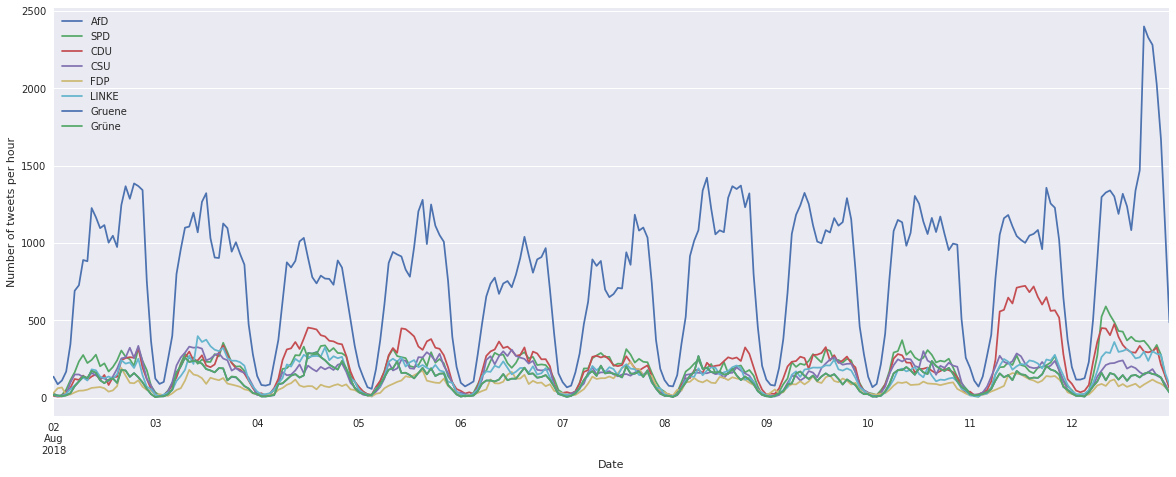

In [18]:
plt.figure(figsize=(20, 7.5))
ax = plt.axes()
for party in parties:
    data[party].loc[:, 'full_text'].resample('h').count().plot(ax=ax, label=party)
plt.legend()
plt.ylabel("Number of tweets per hour")
plt.xlabel("Date") 
# ax.grid(axis='both')
plt.show()

In [6]:
def plot_tweetcount(df_list):
    """
    Interactive plotly plot that shows exactly the same data as the previous plot but is interactive.
    """
    
#     define color for the respective party !sequence matters!
    party_colors = [['AfD', 'rgb(26, 124, 199)'],
                    ['SPD', 'rgb(210, 0, 0)'], 
                    ['CDU', 'rgb(0, 29, 77)'], 
                    ['CSU', 'rgb(26, 117, 255)'], 
                    ['LINKE', 'rgb(204, 0, 102)'], 
                    ['FDP', 'rgb(255, 204, 0)'], 
                    ['Gruene', 'rgb(0, 204, 0)']]
    
    traces = []

   
    for party, color in party_colors:
#         define the number of tweets per hour
        df = df_list[party]
        tweetcount = pd.DataFrame(df.loc[:, 'full_text'].
                                  resample('h').
                                  count())
#     define the traces for the plotly plot
        trace = go.Scatter(y = tweetcount.loc[:, 'full_text'],
                           x = tweetcount.index,
                           line = {'color': color},
                           name = party)
        traces.append(trace)
        
    
    layout = go.Layout(title='Party tweet-count per hour',
                       yaxis = dict(title='Tweets per hour'),
                       xaxis = dict(title='Days'))
    
    hourly_tweetcount = go.Figure(data=traces, layout=layout)
    py.offline.iplot(hourly_tweetcount)

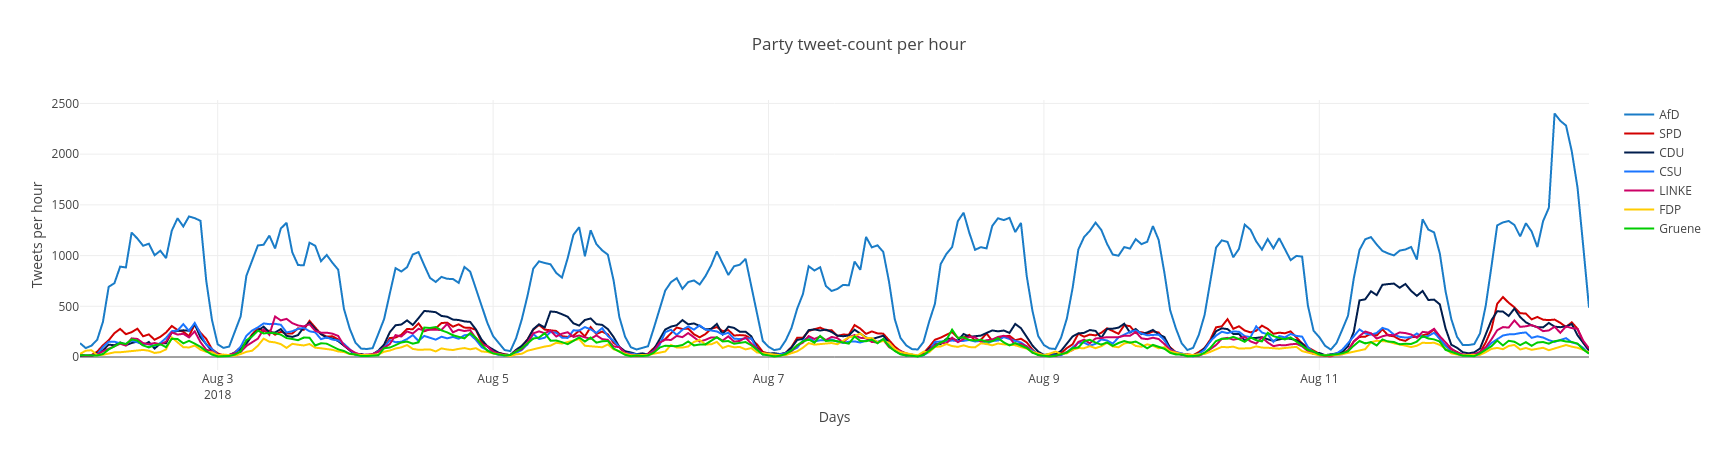

In [7]:
plot_tweetcount(data)

# Feature extraction and first clustering - 'quick and dirty'
1. Vectorization and standardization
2. Dimensionality reduction
3. Clustering

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [9]:
vectorizer = CountVectorizer() # transforms text data to sparse vector of numbers
scaler = StandardScaler(with_mean = False) # standardises the numbers -> values with mean 0 and std of 1
svd = TruncatedSVD(n_components = 2, 
                   random_state = 123) # dimensionality reduction; svd can handle sparse data, PCA can't

preprocessing_pipe = Pipeline(steps = [('vectorizer', vectorizer), 
                                       ('scaler', scaler), 
                                       ('svd', svd)])



kmeans_clsf = KMeans(n_clusters=3, # number of desired clusters
                     random_state=123, 
                     n_init = 10, # run algorithm 10 times independently with different random centroids to choose the final model as the one with lowest sse
                     init='random', 
                     max_iter=50, # max number of iterations per single run
                     tol=1e-04) # controls tolerance with regard to the changes in the within-cluster sse to declare convergence

In [13]:
def first_clustering(dict_of_df):
    parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene']
    X = {}
    y_km = {}
    text = {}
    centers = {}
    
    
    for party in parties:
        df = data[party]
        text[party] = (df.loc[:, 'full_text']).tolist()

        X[party] = preprocessing_pipe.fit_transform(text[party])

        y_km[party] = kmeans_clsf.fit_predict(X[party])
        centers[party] = kmeans_clsf.cluster_centers_
        
    return X, y_km, centers

In [14]:
X, y_km, centers = first_clustering(data)

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConvers

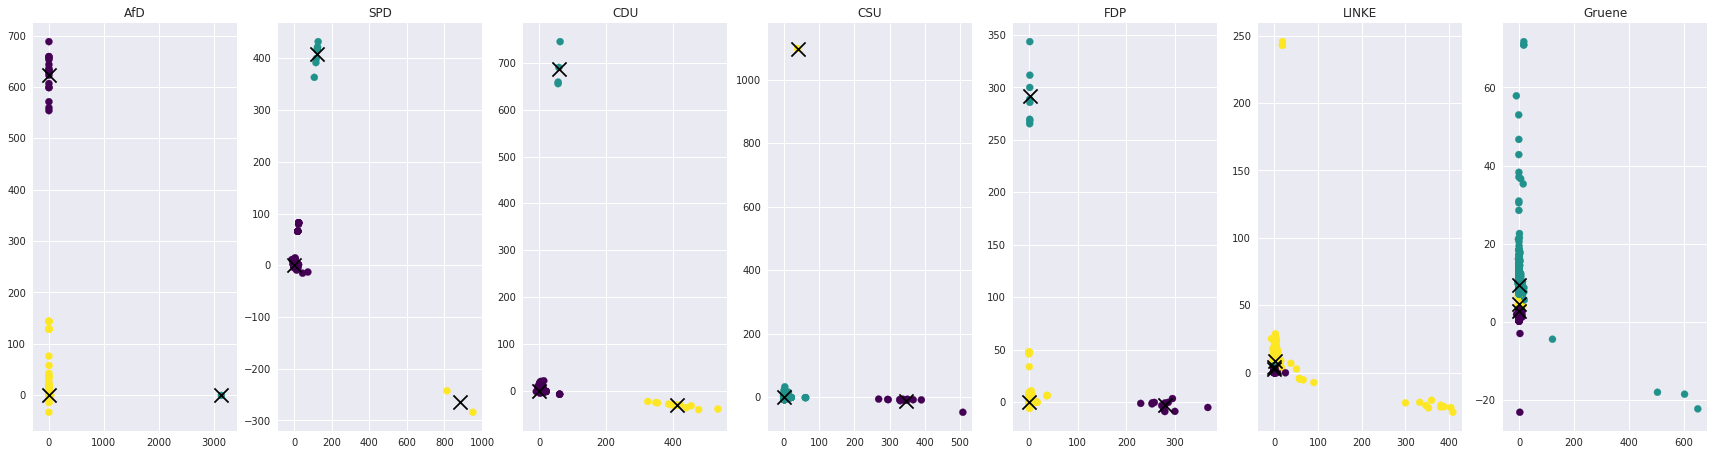

In [15]:
f, axarr = plt.subplots(1, 7, figsize=(30, 7.5))
parties_short = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene']

for i, party in enumerate(parties_short):
    ax = axarr[i]
    
    ax.scatter(X[party][:, 0], X[party][:, 1], c=y_km[party], s=50, cmap='viridis')
    ax.set_title(party)

    center = centers[party]
    ax.scatter(center[:, 0], center[:, 1], c='black', s=200, marker='x');

# Create one dataframe containing all data without duplicates

Having separate dataframes for each party only makes limited sense: many parties are mentioned more than once, thus there are many duplicates in the data. Whether only one party is mentioned in a given tweet can be deduced from the subsequently created columns 'tags', 'mentions', and 'parties'.

In [ ]:
def collapse_dfs(df_dict):
    """
    Fun"""
    parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne', 'spdde']
    all_data = pd.DataFrame()

    for party in parties:
        df = data[party]
        all_data = all_data.append(df)

    all_data = all_data.drop_duplicates().drop("created_at", axis=1)
    
    return all_data

In [8]:
all_data = collapse_dfs(data)
print(all_data.shape)

(367111, 2)


# Quick and dirty clustering full dataframe

1. Elbow visualizer to define number of clusters
2. KMeans for full dataframe

In [54]:
def text_preprocessing(df):
    
    """prepare text for the ElbowVisualizer """
    X2 = {}
    
    text = (df.loc[:, 'full_text']).tolist()

    X2 = preprocessing_pipe.fit_transform(text)
        
    return X2

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f3c2304a8>,
         k=None, metric=None, model=None, timings=True)

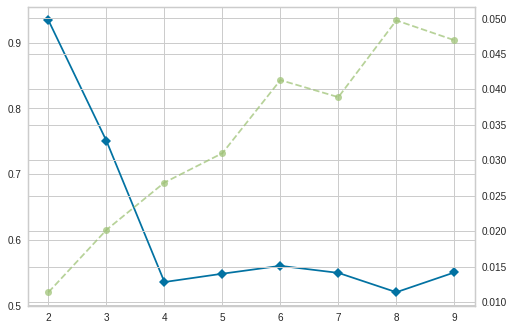

In [53]:
"""Use the elbow visualizer to find the optimal number of clusters for KMeans"""

from yellowbrick.cluster import KElbowVisualizer

X3 = text_preprocessing(all_data)
X3_short = X3[:1000] # take only the first 1000 > ran out of memory using all data

visualizer = KElbowVisualizer(KMeans(), metric='silhouette', k=[2, 10])
visualizer.fit(X3_short)

In [45]:
""" define KMeans with the optimal number of clusters derived from the elbow visualizer"""

kmeans_clsf2 = KMeans(n_clusters=4, # number of desired clusters
                     random_state=123, 
                     n_init = 10, # run algorithm 10 times independently with different random centroids to choose the final model as the one with lowest sse
                     init='random', 
                     max_iter=50, # max number of iterations per single run
                     tol=1e-04) # controls tolerance with regard to the changes in the within-cluster sse to declare convergence

In [50]:
def second_clustering(df):
    """
    Function used to prepare text data for KMeans classifier (use preprocessing pipelins) 
    and to apply KMeans 
    returns feature "coordinates" (X2), cluster (y_km2), and cluster centers (centers2)"""
    
    
    X2 = {}
    y_km2 = {}
    centers2 = {}

    text = (df.loc[:, 'full_text']).tolist()

    X2 = preprocessing_pipe.fit_transform(text)

    y_km2 = kmeans_clsf2.fit_predict(X2)
    centers2 = kmeans_clsf2.cluster_centers_
        
    return X2, y_km2, centers2

In [51]:
X2, y_km2, centers2 = second_clustering(all_data)

/home/franzi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



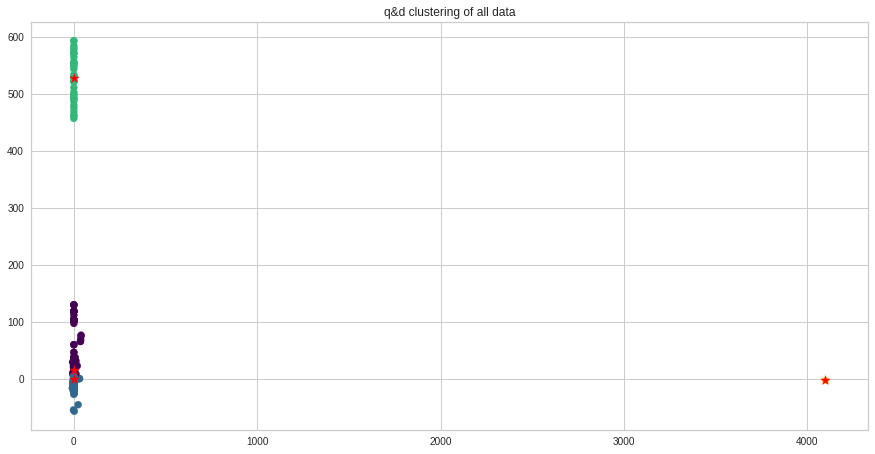

In [57]:
""" Plot features, cluster and cluster centers"""

plt.figure(figsize=(15, 7.5))
plt.scatter(X2[:, 0], X2[:, 1], c=y_km2, s=50, cmap='viridis')
plt.scatter(centers2[:, 0], centers2[:, 1], c='red', s=100, marker='*')
plt.title('q&d clustering of all data')
plt.show()

# Extract hashtags and party mentions
Create columns 'tags', 'clean_text', 'mentions', and 'parties'

- tags: hashtags found in the full tweet
- parties: parties mentioned without hashtag
- clean_text: hashtags and special characters removed from full_text

In [125]:
# removes special characters from text - # and @ to be removed together with the subsequent word in separate function
text_cleaner = lambda x: " ".join(re.findall(r"[A-Za-z0-9üäöÜÄÖß#@ ]*", x))

# extracts hashtags+subsequent word from full_text
tag_finder = lambda x: re.findall(r"#(\w+)", x)

# removes hashtags+subsequent word from full_text
tag_remover = lambda x: re.sub("#(\w+)", '', x)

# extracts mentions(@) and subsequent word
at_finder = lambda x: re.findall("@(\w+)", x)

# removes mentions(@) and subsequent word
at_remover = lambda x: re.sub("@(\w+)", '', x)

# finds all parties mentioned in text after hashtags are removed
def party_finder(x):
    parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
    text = x.lower()
    out = []
    for party in parties:
        if party.lower() in text:
            out.append(party)
    return out

In [16]:
def text_processing(dict_of_DFs, parties):
    """
    Function to remove special characters and extract hashtags, parties, mentions from a dictionary of dataframes
    """
    
    for party in parties:
        df = dict_of_DFs[party]
        df['tags'] = df['full_text'].apply(tag_finder)
        df['clean_text'] = df['full_text'].apply(text_cleaner).apply(tag_remover).astype('str')
        df['parties'] = df['clean_text'].map(party_finder)

In [17]:
text_processing(data, parties)

In [156]:
def all_processing(df):
    """
    Function to remove special characters and extract hashtags, parties, mentions from a dataframe
    """
    
    df['tags'] = df['full_text'].apply(tag_finder)
    df['mentions'] = df['full_text'].apply(at_finder)
    df['clean_text'] = df['full_text'].apply(text_cleaner)\
                                      .apply(tag_remover)\
                                      .apply(at_remover)
    df['parties'] = df['clean_text'].map(party_finder)

In [157]:
all_processing(all_data)

In [158]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 367111 entries, 2018-08-02 00:00:14 to 2018-08-04 20:58:07
Data columns (total 6 columns):
id_str        367111 non-null int64
full_text     367111 non-null object
tags          367111 non-null object
mentions      367111 non-null object
clean_text    367111 non-null object
parties       367111 non-null object
dtypes: int64(1), object(5)
memory usage: 29.6+ MB


# Feature extraction: finetuning for clustering without the q&d

- hash the tags
- vectorize the text